In [1]:
run_gridsearch = True
skip_best_model_train = False                  
GPU_SETTING = -1
NUM_ENSEMBLES = 5
hyperparam_csv_file = "warm_springs_mts2_hyperparams.csv"

In [2]:
import sys
import os
import itertools
current_dir = os.getcwd()
print(current_dir)

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all


In [3]:
library_path = os.path.join('..', '..', '..','..','UCB-USACE-LSTMs')
sys.path.insert(0, library_path)
print(sys.path)

['../../../../UCB-USACE-LSTMs', '/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all', '/Users/canruso/Desktop', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python310.zip', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/lib-dynload', '', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages', '/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/setuptools/_vendor']


In [4]:
from pathlib import Path
from neuralhydrology.evaluation.metrics import *
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import (combinedPlot, fancyCombinedPlot, combinedPlotFromDf, fancyCombinedPlotFromDf)

In [5]:
# Dynamically find the repo root from the current working directory
current_path = os.getcwd()
library_path = current_path.split('UCB-USACE-LSTMs')[0] + 'UCB-USACE-LSTMs'

# Construct the target path
target_path = os.path.join(library_path, 'UCB_training', 'models', 'warm_springs_all')

# Verify if the directory exists before changing
if os.path.exists(target_path):
    os.chdir(target_path)
    print("Current Working Directory:", os.getcwd())
    print("Train Basin File Exists:", os.path.exists("warm springs")) 
else:
    print(f"Error: The target path '{target_path}' does not exist.")

Current Working Directory: /Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all
Train Basin File Exists: True


In [6]:
path_to_csv = Path(library_path +'/russian_river_data')
path_to_yaml = Path("warm_springs_mtslstm2.yaml")
path_to_physics_data_1D = Path(library_path + "/russian_river_data/WarmSprings_Inflow_daily_averaged.csv")
path_to_physics_data_1H = Path(library_path + "/russian_river_data/WarmSprings_Inflow_hourly.csv")

In [7]:
features_with_physics = [
    #from daily.csv
    "DRY CREEK 20 PRECIP-INC SCREENED",
    "DRY CREEK 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "DRY CREEK 30 PRECIP-INC SCREENED",
    "DRY CREEK 30 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    "SANTA ROSA CA HUMIDITY USAF-NOAA",
    "SANTA ROSA CA SOLAR RADIATION USAF-NOAA",
    "SANTA ROSA CA TEMPERATURE USAF-NOAA",
    "SANTA ROSA CA WINDSPEED USAF-NOAA",
    #from Warm_Spring_Inflow.csv
    'Dry Creek 20 ET-POTENTIAL',
    'Dry Creek 20 FLOW',
    'Dry Creek 20 FLOW-BASE',
    'Dry Creek 20 INFILTRATION',
    'Dry Creek 20 PERC-SOIL',
    'Dry Creek 20 SATURATION FRACTION',
    'Dry Creek 30 ET-POTENTIAL',
    'Dry Creek 30 FLOW',
    'Dry Creek 30 FLOW-BASE',
    'Dry Creek 30 INFILTRATION',
    'Dry Creek 30 PERC-SOIL',
    'Dry Creek 30 SATURATION FRACTION',
    'Warm Springs Dam Inflow FLOW',
]

In [8]:
hyperparam_space = {
    "hidden_size": [64, 128, 256],
    "seq_length_1D": [90, 120],
    "seq_length_1H": [168, 336],
    "num_layers": [1],
    "epochs": [16, 32, 48],
    "batch_size": [64, 128],
    "schedule_pairs": [
        ((0.5, 0.3), (0.01, 0.005, 0.001)),
        ((0.4, 0.4), (0.02, 0.005, 0.001))
    ]
}

fixed_dropout = 0.4
no_physics_results = []
physics_results = []

In [ ]:
# starting time in UTC time
from datetime import datetime
start_time = datetime.utcnow()
print("Start time:", start_time.strftime("%Y-%m-%d %H:%M:%S"))

In [9]:
if run_gridsearch or not os.path.exists(hyperparam_csv_file):
    for (hs, seqD, seqH, nl, ep, bs, schedule_pair) in itertools.product(
            hyperparam_space["hidden_size"],
            hyperparam_space["seq_length_1D"],
            hyperparam_space["seq_length_1H"],
            hyperparam_space["num_layers"],
            hyperparam_space["epochs"],
            hyperparam_space["batch_size"],
            hyperparam_space["schedule_pairs"]):

        (f1, f2), (lr1, lr2, lr3) = schedule_pair

        fractions = [f1, f2]
        lr_list = [lr1, lr2, lr3]

        lr_dict = fractional_multi_lr(
            epochs=ep,
            fractions=fractions,
            lrs=lr_list,
            round_up=True)


        hp = {
            "hidden_size": hs,
            "seq_length": {"1D": seqD, "1H": seqH},
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout,
            "batch_size": bs,
            "learning_rate": lr_dict
        }

        print(f"\nNoPhysics MTS: {hp}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp,
            input_features=None,
            physics_informed=False,
            physics_data_file=None,
            hourly=True,  
            extend_train_period=False,
            gpu=GPU_SETTING,
            is_mts = True
        )
        trainer.train()
        csv_1d, metrics_1d = trainer.results(period="validation", mts_trk="1D")
        csv_1h, metrics_1h = trainer.results(period="validation", mts_trk="1H")

        row_data = {
            "hidden_size": hs,
            "seq_length_1D": seqD,
            "seq_length_1H": seqH,
            "num_layers": nl,
            "epochs": ep,
            "batch_size": bs,
            "learning_rate": str(lr_dict),
            "output_dropout": fixed_dropout,
            "NSE_1D": metrics_1d.get("NSE", 0),
            "NSE_1H": metrics_1h.get("NSE", 0)
        }
        
        no_physics_results.append(row_data)

    df_no_physics = pd.DataFrame(no_physics_results)
    df_no_physics.sort_values(by="NSE_1D", ascending=False, inplace=True)
    df_no_physics.reset_index(drop=True, inplace=True)
else:
    print("Skipping grid search!")

Skipping grid search!


In [10]:
if run_gridsearch or not os.path.exists(hyperparam_csv_file):
    for (hs, seqD, seqH, nl, ep, bs, schedule_pair) in itertools.product(
            hyperparam_space["hidden_size"],
            hyperparam_space["seq_length_1D"],
            hyperparam_space["seq_length_1H"],
            hyperparam_space["num_layers"],
            hyperparam_space["epochs"],
            hyperparam_space["batch_size"],
            hyperparam_space["schedule_pairs"]):

        (f1, f2), (lr1, lr2, lr3) = schedule_pair

        fractions = [f1, f2]
        lr_list = [lr1, lr2, lr3]

        lr_dict = fractional_multi_lr(
            epochs=ep,
            fractions=fractions,
            lrs=lr_list,
            round_up=True)


        hp = {
            "hidden_size": hs,
            "seq_length": {"1D": seqD, "1H": seqH},
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout,
            "batch_size": bs,
            "learning_rate": lr_dict
        }

        print(f"\nPhysics MTS: {hp}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp,
            input_features=features_with_physics,
            physics_informed=True,
            physics_data_file=path_to_physics_data_1H,
            hourly=True,
            extend_train_period=False,
            gpu=GPU_SETTING,
            is_mts = True,
        )
        trainer.train()
        csv_1d, metrics_1d = trainer.results(period="validation", mts_trk="1D")
        csv_1h, metrics_1h = trainer.results(period="validation", mts_trk="1H")

        row_data = {
            "hidden_size": hs,
            "seq_length_1D": seqD,
            "seq_length_1H": seqH,
            "num_layers": nl,
            "epochs": ep,
            "batch_size": bs,
            "learning_rate": str(lr_dict),
            "output_dropout": fixed_dropout,
            "NSE_1D": metrics_1d.get("NSE", 0),
            "NSE_1H": metrics_1h.get("NSE", 0)
        }
        
        physics_results.append(row_data)
        
    df_physics = pd.DataFrame(physics_results)
    df_physics.sort_values(by="NSE_1D", ascending=False, inplace=True)
    df_physics.reset_index(drop=True, inplace=True)
    best_no_phys = df_no_physics.iloc[0].to_dict()
    best_phys = df_physics.iloc[0].to_dict()
    best_no_phys["model_type"] = "no_physics"
    best_phys["model_type"] = "physics"
    best_params_df = pd.DataFrame([best_no_phys, best_phys])
    best_params_df.to_csv(hyperparam_csv_file, index=False)
else:
    print("Skipping grid search!")

Skipping grid search!


In [11]:
if run_gridsearch:
    print(df_no_physics.iloc[0:4])
    df_no_physics.to_csv("warm_springs_mts2_no_physics_gridsearch.csv", index=False)

In [12]:
if run_gridsearch:
    print(df_physics.iloc[0:4])
    df_physics.to_csv("warm_springs_mts2_physics_gridsearch.csv", index=False)

In [13]:
if os.path.exists(hyperparam_csv_file):
    best_params_df = pd.read_csv(hyperparam_csv_file)
    best_no_phys = best_params_df.query("model_type == 'no_physics'").iloc[0].to_dict()
    best_phys = best_params_df.query("model_type == 'physics'").iloc[0].to_dict()

    best_no_physics_params = {
        "epochs": int(best_no_phys["epochs"]),
        "hidden_size": int(best_no_phys["hidden_size"]),
        "seq_length": {
            "1D": int(best_no_phys["seq_length_1D"]),
            "1H": int(best_no_phys["seq_length_1H"])
        },
        "num_layers": int(best_no_phys["num_layers"]),
        "output_dropout": float(best_no_phys["output_dropout"]),
        "batch_size": int(best_no_phys["batch_size"]),
        "learning_rate": eval(best_no_phys["learning_rate"])
    }

    best_physics_params = {
        "epochs": int(best_phys["epochs"]),
        "hidden_size": int(best_phys["hidden_size"]),
        "seq_length": {
            "1D": int(best_phys["seq_length_1D"]),
            "1H": int(best_phys["seq_length_1H"])
        },
        "num_layers": int(best_phys["num_layers"]),
        "output_dropout": float(best_phys["output_dropout"]),
        "batch_size": int(best_phys["batch_size"]),
        "learning_rate": eval(best_phys["learning_rate"])
    }
    print("Loaded best hyperparams from CSV:")
    print("Best NO-PHYS:", best_no_physics_params)
    print("Best PHYS:", best_physics_params)
else:
    print(f"Error: {hyperparam_csv_file} not found. Did you run gridsearch?")

Loaded best hyperparams from CSV:
Best NO-PHYS: {'epochs': 32, 'hidden_size': 64, 'seq_length': {'1D': 120, '1H': 168}, 'num_layers': 1, 'output_dropout': 0.4}
Best PHYS: {'epochs': 16, 'hidden_size': 128, 'seq_length': {'1D': 120, '1H': 168}, 'num_layers': 1, 'output_dropout': 0.4}


In [14]:
if not skip_best_model_train:
    noPhysValTrainer = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=True,
        extend_train_period=False,
        gpu=GPU_SETTING,
        is_mts = True
    )
    noPhysValTrainer.train()
    noPhys_val_csv_1D, noPhys_val_metrics_1D = noPhysValTrainer.results(period="validation", mts_trk="1D")
    noPhys_val_csv_1H, noPhys_val_metrics_1H = noPhysValTrainer.results(period="validation", mts_trk="1H")
    print("NO-PHYS VAL 1D => NSE =", noPhys_val_metrics_1D.get("NSE", None))
    print("NO-PHYS VAL 1H => NSE =", noPhys_val_metrics_1H.get("NSE", None))

In [15]:
if not skip_best_model_train:
    physValTrainer = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data_1H,
        hourly=True,
        extend_train_period=False,
        gpu=GPU_SETTING,
        is_mts = True
    )
    physValTrainer.train()
    phys_val_csv_1D, phys_val_metrics_1D = physValTrainer.results(period="validation", mts_trk="1D")
    phys_val_csv_1H, phys_val_metrics_1H = physValTrainer.results(period="validation", mts_trk="1H")
    print("PHYS VAL 1D => NSE =", phys_val_metrics_1D.get("NSE", None))
    print("PHYS VAL 1H => NSE =", phys_val_metrics_1H.get("NSE", None))

[INFO] Wrote metrics CSV: warm_springs_mts2_val_metrics_1D.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/ut

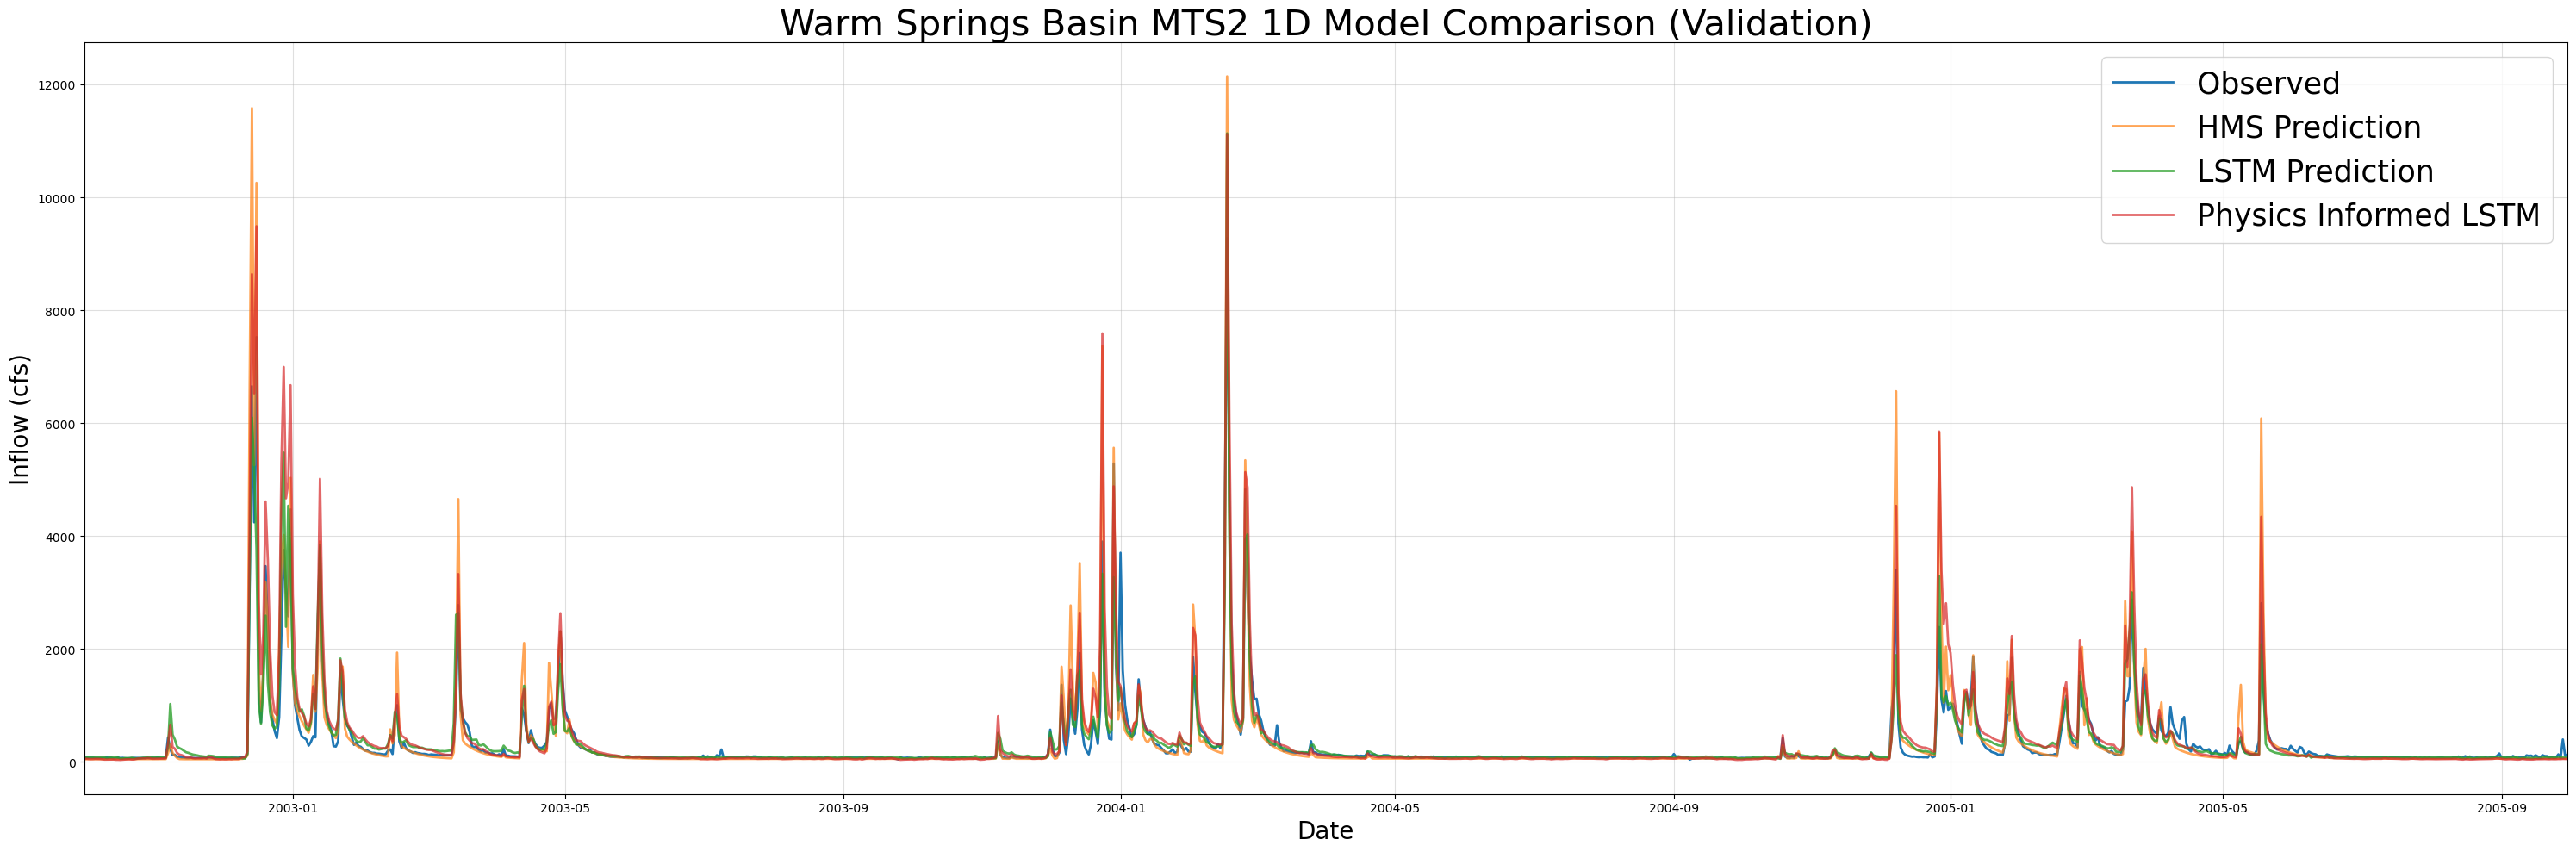

In [16]:
if not skip_best_model_train:
    print("\nPlotting combined MTS results (Validation, 1D)...")
    combinedPlot(
        lstm_results=noPhys_val_csv_1D,
        lstmPhysics_results=phys_val_csv_1D,
        HMS_results=path_to_physics_data_1D,
        title="Warm Springs Basin MTS2 1D Model Comparison (Validation)",
        fName="warm_springs_mts2_val_metrics_1D.csv",
        plot_filename="warm_springs_mts2_val_1D_comparison.png",
        timeseries_filename="warm_springs_mts2_val_1D_combined_ts.csv"
    )
else:
    combined_df_1D = pd.read_csv("warm_springs_mts2_val_1D_combined_ts.csv")
    combinedPlotFromDf(
        combined_df_1D,
        title="Warm Springs Basin MTS2 1D Model Comparison (Validation)",
        fName="warm_springs_mts2_val_metrics_1D.csv"
    )

In [17]:
if not skip_best_model_train:
    fancyCombinedPlot(
        lstm_results=noPhys_val_csv_1D,
        lstmPhysics_results=phys_val_csv_1D,
        HMS_results=path_to_physics_data_1D,
        title="Warm Springs Basin MTS2 1D Model Comparison (Validation)",
        fName="warm_springs_mts2_val_metrics_1D.csv",
        timeseries_filename="warm_springs_mts2_val_1D_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(
        combined_df_1D,
        title="Warm Springs Basin MTS2 1D Model Comparison (Validation)",
        fName="warm_springs_mts2_val_metrics_1D.csv"
    )

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/ut

[INFO] Wrote metrics CSV: warm_springs_mts2_val_metrics_1D.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/can

[INFO] Wrote metrics CSV: warm_springs_mts2_val_metrics_1H.csv


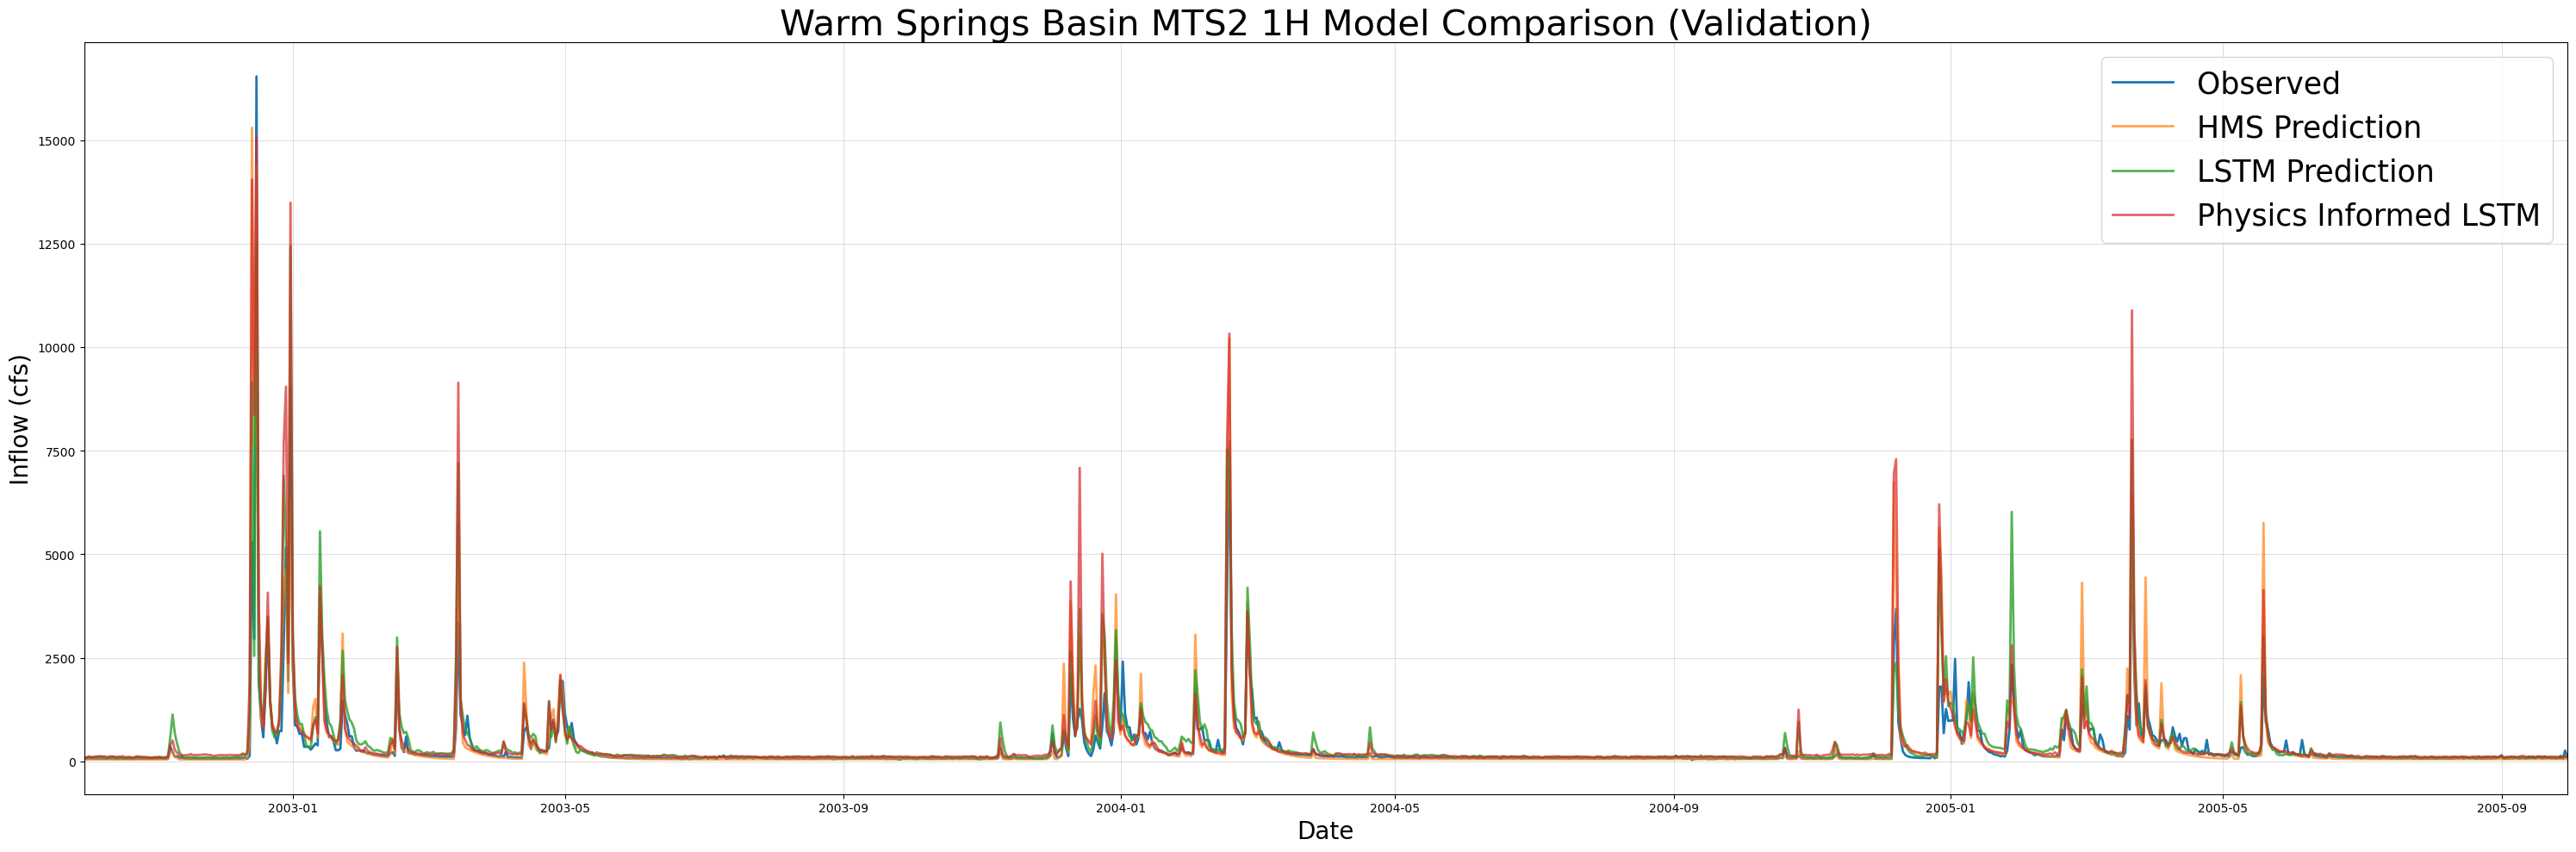

In [18]:
if not skip_best_model_train:
    print("\nPlotting combined MTS results (Validation, 1H)...")
    combinedPlot(
        lstm_results=noPhys_val_csv_1H,
        lstmPhysics_results=phys_val_csv_1H,
        HMS_results=path_to_physics_data_1H,
        title="Warm Springs Basin MTS2 1H Model Comparison (Validation)",
        fName="warm_springs_mts2_val_metrics_1H.csv",
        plot_filename="warm_springs_mts2_val_1H_comparison.png",
        timeseries_filename="warm_springs_mts2_val_1H_combined_ts.csv"
    )
else:
    combined_df_1H = pd.read_csv("warm_springs_mts2_val_1H_combined_ts.csv")
    combinedPlotFromDf(
        combined_df_1H,
        title="Warm Springs Basin MTS2 1H Model Comparison (Validation)",
        fName="warm_springs_mts2_val_metrics_1H.csv"
    )

In [19]:
if not skip_best_model_train:
    fancyCombinedPlot(
        lstm_results=noPhys_val_csv_1H,
        lstmPhysics_results=phys_val_csv_1H,
        HMS_results=path_to_physics_data_1H,
        title="Warm Springs Basin MTS2 1H Model Comparison (Validation)",
        fName="warm_springs_mts2_val_metrics_1H.csv",
        timeseries_filename="warm_springs_mts2_val_1H_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(
        combined_df_1H,
        title="Warm Springs Basin MTS2 1H Model Comparison (Validation)",
        fName="warm_springs_mts2_val_metrics_1H.csv"
    )

[INFO] Wrote metrics CSV: warm_springs_mts2_val_metrics_1H.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/can

In [20]:
if skip_best_model_train:
    val_metrics = pd.read_csv("warm_springs_mts2_val_metrics_1D.csv")
    print(val_metrics)

     Unnamed: 0            HMS          LSTM  Physics_Informed_LSTM
0           NSE       0.702997      0.869278               0.716787
1           MSE  145771.208225  64159.343046          139003.047584
2          RMSE     381.799958    253.296946             372.831125
3           KGE       0.630113      0.921482               0.541023
4     Alpha-NSE       1.353911      0.971873               1.374916
5      Beta-KGE       1.087276      1.030319               1.260636
6      Beta-NSE       0.040554      0.014088               0.121108
7     Pearson-r       0.937180      0.933257               0.953458
8           FHV      34.586094     -4.103705              39.009147
9           FMS      11.837239      1.555315              33.794538
10          FLV      73.796647     39.816695              32.613851
11  Peak-Timing       0.000000      0.400000               0.000000
12    Peak-MAPE      40.469933     28.813505              32.509968


In [21]:
if skip_best_model_train:
    val_metrics = pd.read_csv("warm_springs_mts2_val_metrics_1H.csv")
    print(val_metrics)

     Unnamed: 0            HMS           LSTM  Physics_Informed_LSTM
0           NSE       0.601062       0.739032               0.435677
1           MSE  262553.178659  171751.086308          371397.916671
2          RMSE     512.399433     414.428626             609.424250
3           KGE       0.674028       0.595653               0.402281
4     Alpha-NSE       1.279143       1.187380               1.469662
5      Beta-KGE       1.113086       1.347562               1.352881
6      Beta-NSE       0.044872       0.137912               0.140022
7     Pearson-r       0.875306       0.912902               0.889725
8           FHV      38.811476      29.726281              70.779192
9           FMS      11.726467      -1.528124             -19.948084
10          FLV      76.026221      16.501015              61.224726
11  Peak-Timing       0.400000       0.400000               0.200000
12    Peak-MAPE      15.890879      25.698099              51.061032


# Test Period

In [22]:
if not skip_best_model_train:
    print("\nTraining No-Physics MTS2 model for test period...")
    mtsNoPhysicsTest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=True,
        extend_train_period=True,
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
        is_mts = True
    )
    mtsNoPhysicsTest.train()
    no_physics_test_csv_1D, no_physics_test_metrics_1D = mtsNoPhysicsTest.results(period="test", mts_trk="1D")
    no_physics_test_csv_1H, no_physics_test_metrics_1H = mtsNoPhysicsTest.results(period="test", mts_trk="1H")
    print("\n[No-Physics Test] NSE @1D =", no_physics_test_metrics_1D.get("NSE", None))
    print("[No-Physics Test] NSE @1H =", no_physics_test_metrics_1H.get("NSE", None))

In [23]:
if not skip_best_model_train:
    print("\nTraining Physics MTS model for test period...")
    mtsPhysicsTest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data_1H,
        hourly=True,
        extend_train_period=True,
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
        is_mts = True
    )
    mtsPhysicsTest.train()
    physics_test_csv_1D, physics_test_metrics_1D = mtsPhysicsTest.results(period="test", mts_trk="1D")
    physics_test_csv_1H, physics_test_metrics_1H = mtsPhysicsTest.results(period="test", mts_trk="1H")
    print("\n[Physics Test] NSE @1D =", physics_test_metrics_1D.get("NSE", None))
    print("[Physics Test] NSE @1H =", physics_test_metrics_1H.get("NSE", None))

[INFO] Wrote metrics CSV: warm_springs_mts2_test_metrics_1D.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/can

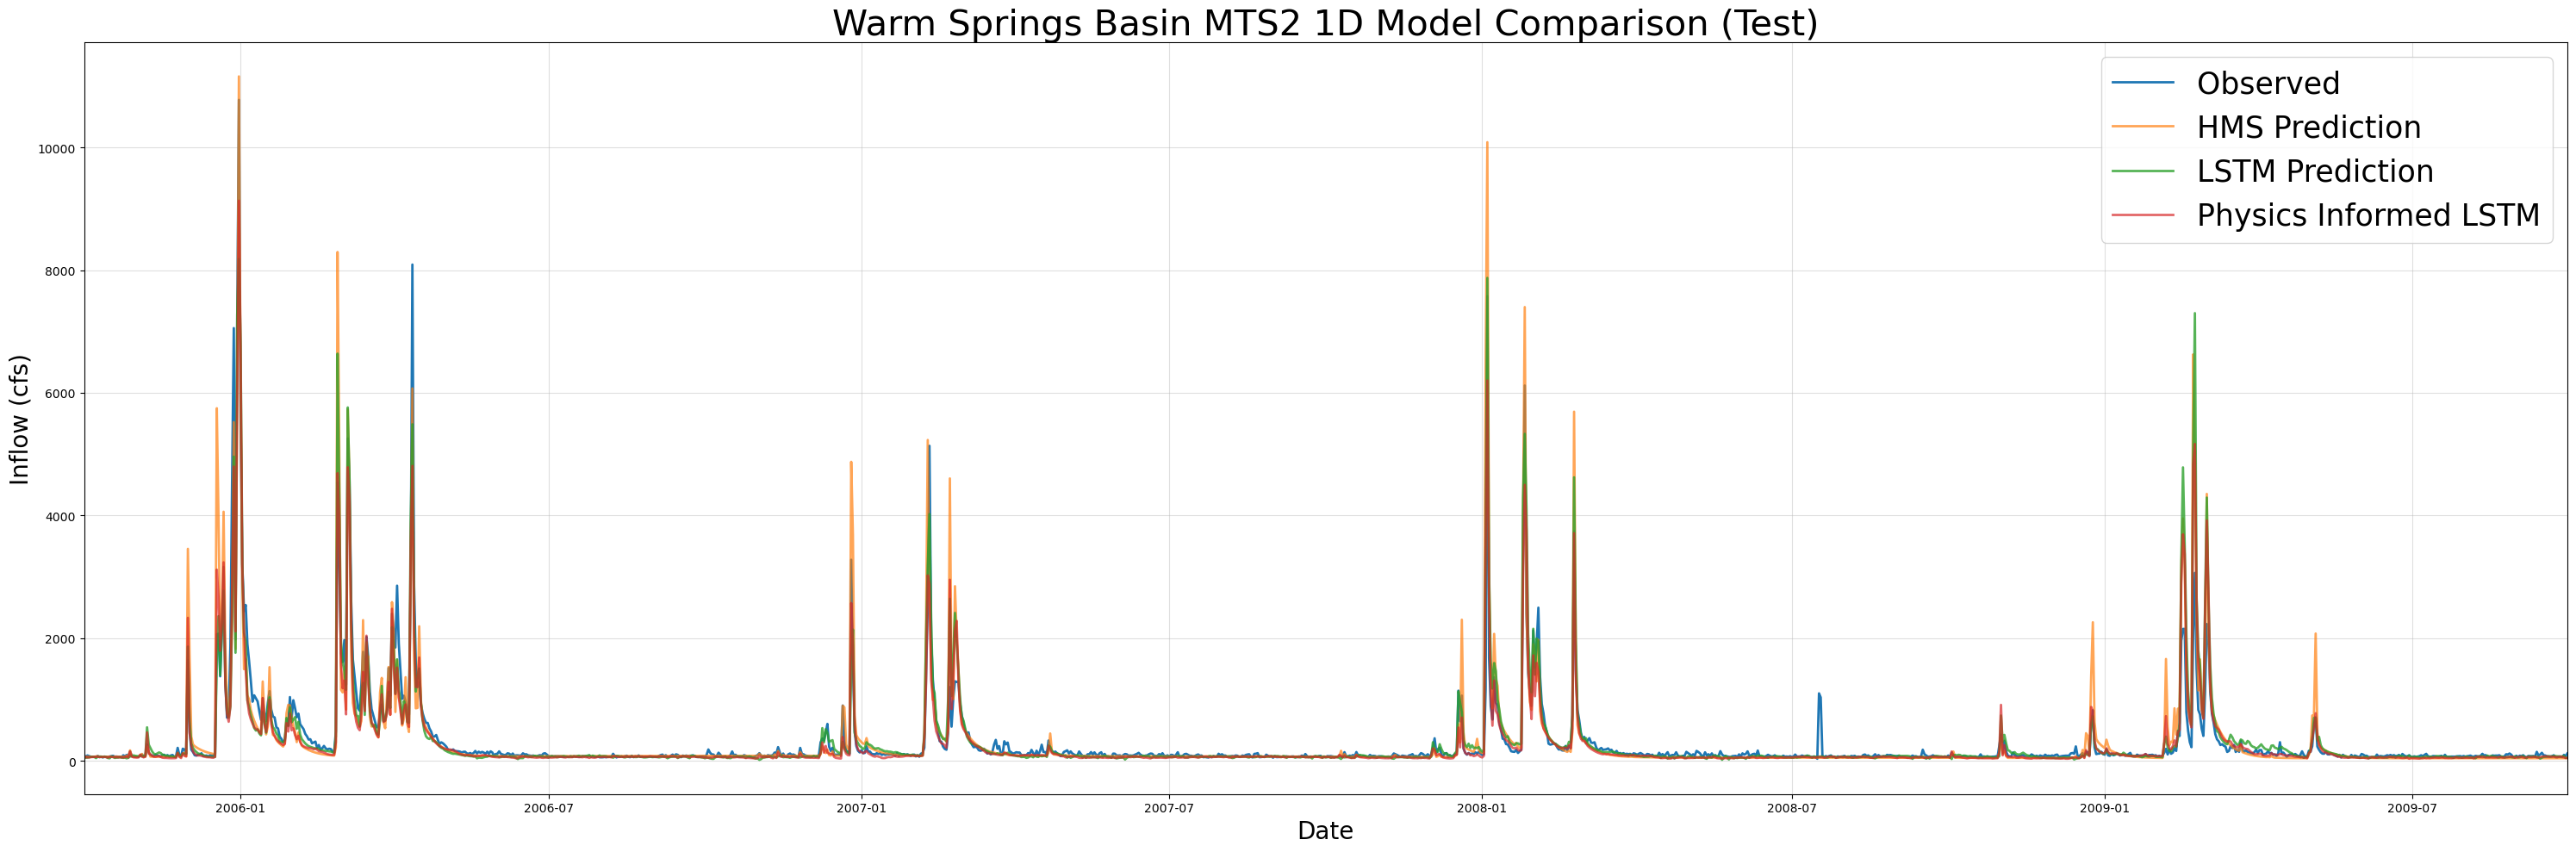

In [24]:
if not skip_best_model_train:
    print("\nPlotting combined MTS2 results (Test, 1D)...")
    combinedPlot(
        lstm_results=no_physics_test_csv_1D,
        lstmPhysics_results=physics_test_csv_1D,
        HMS_results=path_to_physics_data_1D,
        title="Warm Springs Basin MTS2 1D Model Comparison (Test)",
        fName="warm_springs_mts2_test_metrics_1D.csv",
        plot_filename="warm_springs_mts2_test_1D_comparison.png",
        timeseries_filename="warm_springs_mts2_test_1D_combined_ts.csv"
    )
else:
    combined_df_test_1D = pd.read_csv("warm_springs_mts2_test_1D_combined_ts.csv")
    combinedPlotFromDf(
        combined_df_test_1D,
        title="Warm Springs Basin MTS2 1D Model Comparison (Test)",
        fName="warm_springs_mts2_test_metrics_1D.csv"
    )

In [25]:
if not skip_best_model_train:
    fancyCombinedPlot(
        lstm_results=no_physics_test_csv_1D,
        lstmPhysics_results=physics_test_csv_1D,
        HMS_results=path_to_physics_data_1D,
        title="Wrm Springs Basin MTS2 1D Model Comparison (Test)",
        fName="warm_springs_mts2_test_metrics_1D.csv",
        timeseries_filename="warm_springs_mts2_test_1D_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(
        combined_df_test_1D,
        title="Warm Springs Basin MTS2 1D Model Comparison (Test)",
        fName="warm_springs_mts2_test_metrics_1D.csv"
    )

[INFO] Wrote metrics CSV: warm_springs_mts2_test_metrics_1D.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/can

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/can

[INFO] Wrote metrics CSV: warm_springs_mts2_test_metrics_1H.csv


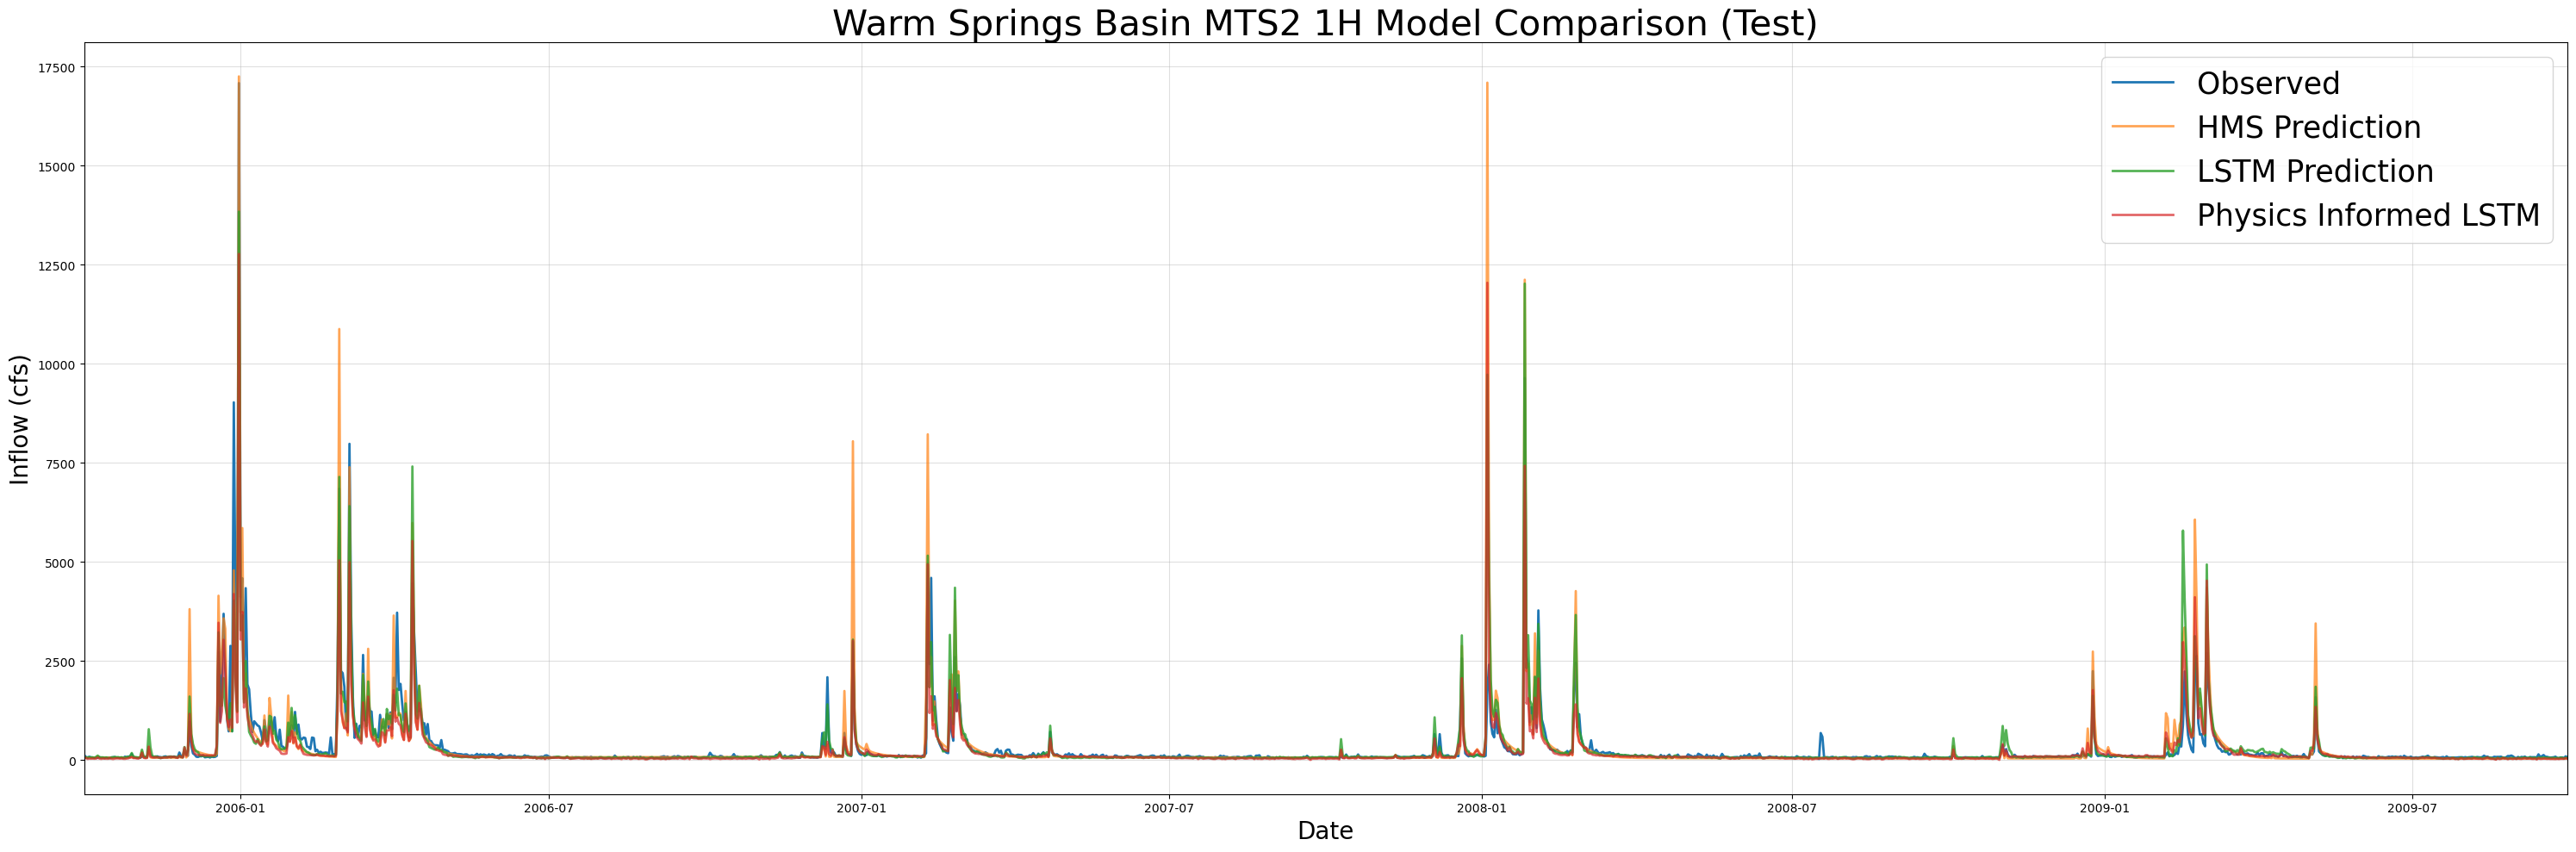

In [26]:
if not skip_best_model_train:
    print("\nPlotting combined MTS2 results (Test, 1H)...")
    combinedPlot(
        lstm_results=no_physics_test_csv_1H,
        lstmPhysics_results=physics_test_csv_1H,
        HMS_results=path_to_physics_data_1H,
        title="Warm Springs Basin MTS2 1H Model Comparison (Test)",
        fName="warm_springs_mts2_test_metrics_1H.csv",
        plot_filename="warm_springs_mts2_test_1H_comparison.png",
        timeseries_filename="warm_springs_mts2_test_1H_combined_ts.csv"
    )
else:
    combined_df_test_1H = pd.read_csv("warm_springs_mts2_test_1H_combined_ts.csv")
    combinedPlotFromDf(
        combined_df_test_1H,
        title="Warm Springs Basin MTS2 1H Model Comparison (Test)",
        fName="warm_springs_mts2_test_metrics_1H.csv"
    )

In [27]:
if not skip_best_model_train:
    fancyCombinedPlot(
        lstm_results=no_physics_test_csv_1H,
        lstmPhysics_results=physics_test_csv_1H,
        HMS_results=path_to_physics_data_1H,
        title="Warm Springs Basin MTS2 1H Model Comparison (Test)",
        fName="warm_springs_mts2_test_metrics_1H.csv",
        timeseries_filename="warm_springs_mts2_test_1H_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(
        combined_df_test_1H,
        title="Warm Springs Basin MTS2 1H Model Comparison (Test)",
        fName="warm_springs_mts2_test_metrics_1H.csv"
    )

[INFO] Wrote metrics CSV: warm_springs_mts2_test_metrics_1H.csv


/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/Users/canruso/Desktop/UCB-USACE-LSTMs/UCB_training/models/warm_springs_all/../../../../UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

/Users/can

In [30]:
if skip_best_model_train:
    test_metrics = pd.read_csv("warm_springs_mts2_test_metrics_1D.csv")
    print(test_metrics)

     Unnamed: 0            HMS          LSTM  Physics_Informed_LSTM
0           NSE       0.735732      0.841634               0.870688
1           MSE  141458.877705  84770.922611           69218.783322
2          RMSE     376.110194    291.154465             263.094628
3           KGE       0.791976      0.913145               0.851286
4     Alpha-NSE       1.179358      1.043436               0.938032
5      Beta-KGE       1.037972      1.005925               0.881822
6      Beta-NSE       0.015441      0.002409              -0.048056
7     Pearson-r       0.901700      0.925020               0.934350
8           FHV      24.812208      9.352610              -2.961697
9           FMS      24.745240     36.090899              25.420581
10          FLV      78.439281    -85.565022              47.365523
11  Peak-Timing       0.833333      0.500000               0.333333
12    Peak-MAPE      44.296877     52.339192              46.880997


In [ ]:
if skip_best_model_train:
    test_metrics = pd.read_csv("warm_springs_mts2_test_metrics_1H.csv")
    print(test_metrics)

In [29]:
# end time in UTC
end_time = datetime.utcnow()
print("End time:", end_time.strftime("%Y-%m-%d %H:%M:%S"))
print("Total time:", end_time - start_time)